In [33]:
import os
import pandas as pd
import ftplib
import codecs
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from datetime import datetime
from zipfile import ZipFile

from matplotlib.ticker import PercentFormatter
from scipy.interpolate import make_interp_spline
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

In [64]:
# Lecture materials were used for the task completion: https://github.com/rolfbecker/MIE_2.02_GeoInfo_WS2020/blob/master/gi0601_DWD_Stations_and_TS_for_TM_soln/gi0601_DWD_Stations_and_TS_for_TM_V002.ipynb

In [34]:
# Connection Parameters
server = "opendata.dwd.de"
user = "anonymous"
passwd = ""

In [35]:
# FTP Directory Definition and Station Description Filename Pattern
# The topic of interest.
topic_dir_ftp = "/hourly/precipitation/historical/"
topic_dir = "/hourly/precipitation/historical/task5/"
# topic_dir = "/annual/kl/historical/"

# This is the search pattern common to ALL station description file names
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir = ftp_climate_data_dir + topic_dir_ftp

In [36]:
# Local Directories
local_dir = "../data/"
local_dtm_data_file = "sample_data.csv"

local_ftp_dir = "../data/original/DWD/"  # Local directory to store local ftp data copies, the local data source or input data.
local_ftp_station_dir = local_ftp_dir + topic_dir  # Local directory where local station info is located
local_ftp_ts_dir = local_ftp_dir + topic_dir  # Local directory where time series downloaded from ftp are located

local_generated_dir = "../data/generated/DWD/"  # The generated of derived data in contrast to local_ftp_dir
local_station_dir = local_generated_dir + topic_dir  # Derived station data, i.e. the CSV file
local_ts_appended_dir = local_generated_dir + topic_dir  # Serially appended time series, long data frame for QGIS TimeManager Plugin
local_ts_dtm_data_dir = local_generated_dir + topic_dir + local_dtm_data_file

In [37]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_appended_dir)

../data/original/DWD/
../data/original/DWD//hourly/precipitation/historical/task5/
../data/original/DWD//hourly/precipitation/historical/task5/

../data/generated/DWD/
../data/generated/DWD//hourly/precipitation/historical/task5/
../data/generated/DWD//hourly/precipitation/historical/task5/


In [38]:
os.makedirs(local_ftp_dir, exist_ok=True)  # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir, exist_ok=True)
os.makedirs(local_ftp_ts_dir, exist_ok=True)

os.makedirs(local_generated_dir, exist_ok=True)
os.makedirs(local_station_dir, exist_ok=True)
os.makedirs(local_ts_appended_dir, exist_ok=True)

In [39]:
# FTP Connect
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd=passwd)
print(res)
ret = ftp.cwd(".")

230 Login successful.


In [40]:
# FTP Grab File Function
def grab_file(ftpfullname, localfullname):
    try:
        ret = ftp.cwd(".")  # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()

    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")

In [41]:
# Generate Pandas Dataframe from FTP Directory Listing
def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:
        res = ftp.retrlines("LIST " + ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return

    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return

    for line in lines:
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
        fext = os.path.splitext(fname)[-1]

        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1

        flist.append([station_id, fname, fext, fsize, ftype])

    df_ftpdir = pd.DataFrame(flist, columns=["station_id", "name", "ext", "size", "type"])
    return (df_ftpdir)

In [42]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [43]:
# Dataframe with TS Zip Files
df_zips = df_ftpdir[df_ftpdir["ext"] == ".zip"]
df_zips.set_index("station_id", inplace=True)  # list of files containing ts
df_zips.head(10)

,name,ext,size,type
station_id,,,,
3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419296,-
20,stundenwerte_RR_00020_20040814_20201231_hist.zip,.zip,432124,-
44,stundenwerte_RR_00044_20070401_20201231_hist.zip,.zip,354983,-
53,stundenwerte_RR_00053_20051001_20201231_hist.zip,.zip,385830,-
71,stundenwerte_RR_00071_20041022_20200101_hist.zip,.zip,402875,-
73,stundenwerte_RR_00073_20070401_20201231_hist.zip,.zip,357529,-
78,stundenwerte_RR_00078_20041101_20201231_hist.zip,.zip,421522,-
87,stundenwerte_RR_00087_20050201_20201231_hist.zip,.zip,403610,-
91,stundenwerte_RR_00091_20040901_20201231_hist.zip,.zip,419182,-


In [44]:
# Retrieve the Station Description File Name
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

RR_Stundenwerte_Beschreibung_Stationen.txt


In [45]:
# Download the Station Description File
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grab_file(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt
To:   ../data/original/DWD//hourly/precipitation/historical/task5/RR_Stundenwerte_Beschreibung_Stationen.txt


In [46]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile, "r", "utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de

    translate = \
        {'Stations_id': 'station_id',
         'von_datum': 'date_from',
         'bis_datum': 'date_to',
         'Stationshoehe': 'altitude',
         'geoBreite': 'latitude',
         'geoLaenge': 'longitude',
         'Stationsname': 'name',
         'Bundesland': 'state'}

    colnames_en = [translate[h] for h in colnames_de]

    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile, skiprows=2, names=colnames_en, parse_dates=["date_from", "date_to"], index_col=0, encoding='windows-1252')

    # write csv
    df.to_csv(csvfile, sep=";")
    return (df)

In [47]:
# Convert Station Description File.txt to Station Description File.csv
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
3,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
20,2004-08-14,2022-03-25,432,48.9219,9.9129,Abtsgmünd-Untergröningen,Baden-Württemberg
29,2006-01-10,2022-03-25,260,49.7175,10.9101,Adelsdorf (Kläranlage),Bayern
44,2007-04-01,2022-03-25,44,52.9336,8.2370,Großenkneten,Niedersachsen
46,2006-01-03,2022-03-25,325,48.9450,12.4639,Aholfing,Bayern


In [48]:
# Select Stations Located in NRW from Station Description Dataframe
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index

# Create variable with TRUE if state is Nordrhein-Westfalen
isNRW = df_stations['state'].str.contains("Nordrhein")

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
#isOperational = df_stations['date_to'] == df_stations.date_to.max()
isOperational = df_stations['date_to'] >= datetime(2018, 1, 1)

# select on both conditions
dfNRW_stations = df_stations[isNRW & isOperational]
# select only stations of interest
interested_stations_indices = (dfNRW_stations.index == 3028) | (dfNRW_stations.index == 14182) | (dfNRW_stations.index == 13700) | (dfNRW_stations.index == 5468) | (
        dfNRW_stations.index == 644) | (dfNRW_stations.index == 14183) | (dfNRW_stations.index == 13713) | (dfNRW_stations.index == 5480) | (
                                      dfNRW_stations.index == 613) | (dfNRW_stations.index == 14185) | (dfNRW_stations.index == 14143) | (dfNRW_stations.index == 5619) | (
                                      dfNRW_stations.index == 796) | (dfNRW_stations.index == 14186) | (dfNRW_stations.index == 14145) | (dfNRW_stations.index == 5699) | (
                                      dfNRW_stations.index == 934) | (dfNRW_stations.index == 14170) | (dfNRW_stations.index == 6264) | (dfNRW_stations.index == 4488) | (
                                      dfNRW_stations.index == 216) | (dfNRW_stations.index == 14171) | (dfNRW_stations.index == 6276) | (dfNRW_stations.index == 4692) | (
                                      dfNRW_stations.index == 389) | (dfNRW_stations.index == 14172) | (dfNRW_stations.index == 6313) | (dfNRW_stations.index == 5347) | (
                                      dfNRW_stations.index == 390) | (dfNRW_stations.index == 14173) | (dfNRW_stations.index == 7330) | (dfNRW_stations.index == 5360) | (
                                      dfNRW_stations.index == 14187) | (dfNRW_stations.index == 4127) | (dfNRW_stations.index == 4313) | (dfNRW_stations.index == 4368) | (
                                      dfNRW_stations.index == 4400) | (dfNRW_stations.index == 3031) | (dfNRW_stations.index == 3098) | (dfNRW_stations.index == 3215) | (
                                      dfNRW_stations.index == 3499) | (dfNRW_stations.index == 1300) | (dfNRW_stations.index == 2483) | (dfNRW_stations.index == 2947)
dfNRW_stations = dfNRW_stations[interested_stations_indices]

In [49]:
dfNRW_stations.shape
#print("Number of stations in NRW: \n", dfNRW.count())

(44, 7)

In [50]:
# Download TS Data from FTP Server
# Add the names of the zip files only to a list.
local_zip_list = []
station_ids_selected = list(dfNRW_stations.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grab_file(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

stundenwerte_RR_00216_20041001_20201231_hist.zip
stundenwerte_RR_00389_20091101_20201231_hist.zip
stundenwerte_RR_00390_20040701_20201231_hist.zip
stundenwerte_RR_00613_20041101_20201231_hist.zip
stundenwerte_RR_00644_20050101_20201231_hist.zip
stundenwerte_RR_00796_20041101_20201231_hist.zip
stundenwerte_RR_00934_20041001_20201231_hist.zip
stundenwerte_RR_01300_20040601_20201231_hist.zip
stundenwerte_RR_02483_19951012_20201231_hist.zip
stundenwerte_RR_02947_20061001_20201231_hist.zip
stundenwerte_RR_03028_19950901_20201231_hist.zip
stundenwerte_RR_03031_20040701_20201231_hist.zip
stundenwerte_RR_03098_19950901_20201231_hist.zip
stundenwerte_RR_03215_20070601_20201231_hist.zip
stundenwerte_RR_03499_20060701_20201231_hist.zip
stundenwerte_RR_04127_20050101_20201231_hist.zip
stundenwerte_RR_04313_20040801_20201231_hist.zip
stundenwerte_RR_04368_20041001_20201231_hist.zip
stundenwerte_RR_04400_20040801_20201231_hist.zip
stundenwerte_RR_04488_20060801_20201231_hist.zip
stundenwerte_RR_0469

In [51]:
# Number of obtained stations
len(local_zip_list)

33

In [52]:
# Join (Merge) the Time Series Columns
def prec_ts_to_df(fname):
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates=["MESS_DATUM"],
                     date_parser=dateparse, na_values=[-999.0, -999])

    # df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)

    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return (df)

In [53]:
# Join TS (containing hourly precipitation data) with df_stations
def ts_append():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0] == "produkt"][0]
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                # TEMPERATURE                dftmp = temp_ts_to_df(myfile)
                # PRECIPIATION
                dftmp = prec_ts_to_df(myfile)
                dftmp = dftmp.merge(df_stations, how="inner", left_on="stations_id", right_on="station_id",
                                    right_index=True)
                #                print(dftmp.head(5))
                df = df.append(dftmp)

    # df.index.names = ["year"]
    # df.index.rename(name = "time", inplace = True)

    return (df)

In [54]:
df_appended_ts = ts_append()

Zip archive: ../data/original/DWD//hourly/precipitation/historical/task5/stundenwerte_RR_00216_20041001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20201231_00216.txt



D:\Programms\python 3.7.5\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


Zip archive: ../data/original/DWD//hourly/precipitation/historical/task5/stundenwerte_RR_00389_20091101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20091101_20201231_00389.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/task5/stundenwerte_RR_00390_20040701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20201231_00390.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/task5/stundenwerte_RR_00613_20041101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041101_20201231_00613.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/task5/stundenwerte_RR_00644_20050101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20050101_20201231_00644.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/task5/stundenwerte_RR_00796_20041101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041101_20201231_00796.txt

Zip archive: ../data/original/DWD//hourly/pre

In [55]:
df_appended_ts.shape

(4724312, 13)

In [56]:
# Select indices with the time period of interest
idx = (df_appended_ts.index >= '2018-04-16 00:00:00') & (df_appended_ts.index < '2018-08-16 01:00:00')
# %%
# Select rows with the time period of interest, get rid of unnecessary columns
df_appended_ts_ex5 = df_appended_ts[idx][["stations_id", "r1", "altitude", "latitude", "longitude"]]

In [57]:
# Sum up precipitation values by station_id
df_total_prec = df_appended_ts_ex5.groupby(['stations_id', 'altitude', 'longitude', 'latitude', ])[
    'r1'].sum().to_frame(name='4_months_precp').reset_index()

In [58]:
# Save cumilative_prec df to csv
filepathname = local_ts_appended_dir + "4_months_total_precipitation .csv"
print("df_appended_ts saved to: %s" % (filepathname))
df_total_prec.to_csv(filepathname, sep=";")

df_appended_ts saved to: ../data/generated/DWD//hourly/precipitation/historical/task5/4_months_total_precipitation .csv


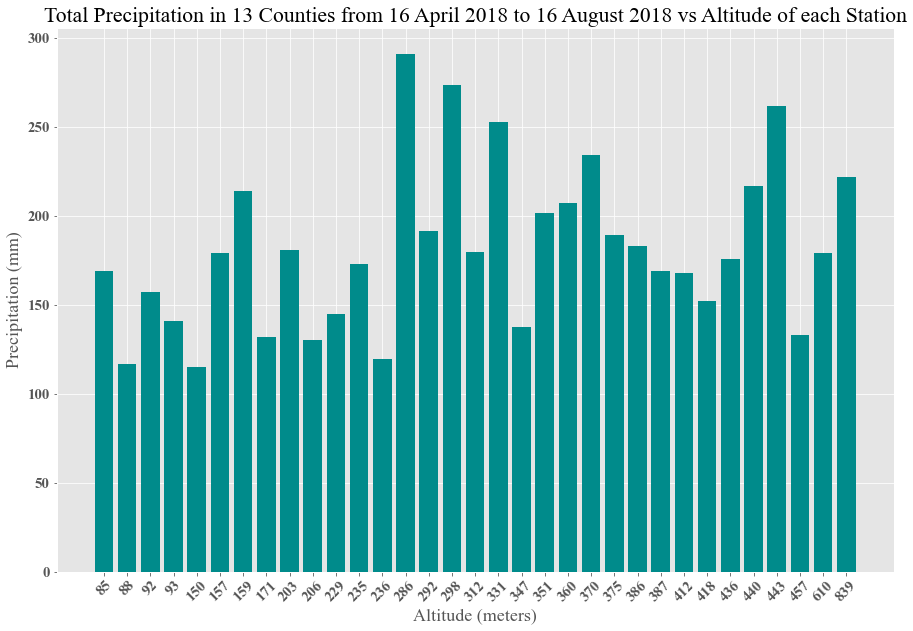

In [59]:
# Total precipitation vs Altitude bar plot
df_total_prec_sorted = df_total_prec.sort_values(by=['altitude'], ascending=True)
plt.style.use('ggplot')
font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 15}
plt.rc('font', **font)
plt.figure(figsize=(15, 10))

plt.bar(df_total_prec_sorted['altitude'].astype(str), df_total_prec_sorted['4_months_precp'],
        linewidth=3.0, color='darkcyan')
plt.ylabel('Precipitation (mm)')
plt.xlabel('Altitude (meters)')
plt.xticks(rotation=45)
plt.title('Total Precipitation in 13 Counties from 16 April 2018 to'
          ' 16 August 2018 vs Altitude of each Station')
plt.show()

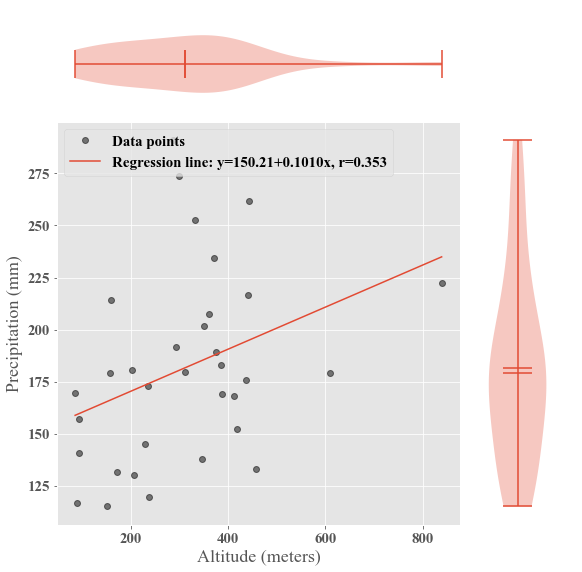

T-statistcs: 2.0978337480024054
P-value: 0.04722163951848576


In [60]:
# Total precipitation vs Altitude regression plot
def regression_plot():
    x = df_total_prec_sorted['altitude']
    y = df_total_prec_sorted['4_months_precp']

    cor_coef = x.corr(y)

    left = 0.1
    bottom = 0.1
    top = 0.8
    right = 0.8
    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
    line = f'Regression line: y={intercept:.2f}+{slope:.4f}x, r={cor_coef:.3f}'
    font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 15}
    plt.rc('font', **font)
    plt.figure(figsize=(8, 8))

    main_ax = plt.axes([left,bottom,right-left,top-bottom])
    # create axes to the top and right of the main axes and hide them
    top_ax = plt.axes([left, top, right - left, 1-top])
    plt.axis('off')
    right_ax = plt.axes([right, bottom, 1-right, top-bottom])
    plt.axis('off')
    main_ax.plot(x,  y, 'ko', alpha=0.5, linewidth=3.0, label='Data points')
    right_ax.violinplot(y, positions=[0], widths=1., showmedians=True,  showmeans=True)
    top_ax.violinplot(x, positions=[0], vert=False, widths=1., showmedians=True, showmeans=True)
    # set the limits to the box axes
    top_ax.set_xlim(main_ax.get_xlim())
    top_ax.set_ylim(-1,1)
    right_ax.set_ylim(main_ax.get_ylim())
    right_ax.set_xlim(-1,1)

    y_est = intercept + slope * x
    main_ax.plot(x, y_est, label=line)
    #main_ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    main_ax.set_xlabel('Altitude (meters)')
    main_ax.set_ylabel('Precipitation (mm)')
    main_ax.legend(loc='upper left')

    plt.show()


def calc_tstat_pearson(pearson_coff, sample_size):
    t = (pearson_coff * np.sqrt(sample_size-2))/np.sqrt(1-(pearson_coff**2))
    return t


def pearson_cor_test():
    x = df_total_prec_sorted['altitude']
    y = df_total_prec_sorted['4_months_precp']
    if len(x) != len(y):
        return 1
    data_size = len(x)
    cor_coef = x.corr(y)
    t_statistics = calc_tstat_pearson(cor_coef, data_size)
    p_value = scipy.stats.t.pdf(t_statistics, df=data_size-1)
    print('T-statistcs: {}'.format(t_statistics))
    print('P-value: {}'.format(p_value))


regression_plot()
pearson_cor_test()

In [61]:
# Comparison of station altitude from Station Metadata file VS altitudes from DTM
# Upload file containing both Station Metadata Altitude vs DTM Altitude
df_dtm = pd.read_csv(local_ts_dtm_data_dir)

In [62]:
# Calculate the difference between two altitudes and save it to the data frame
df_altitude_difference = pd.DataFrame()
df_altitude_difference['stations_id'] = df_dtm['stations_id']
df_altitude_difference['difference'] = abs((df_dtm['altitude_1'] - df_dtm['altitude']))

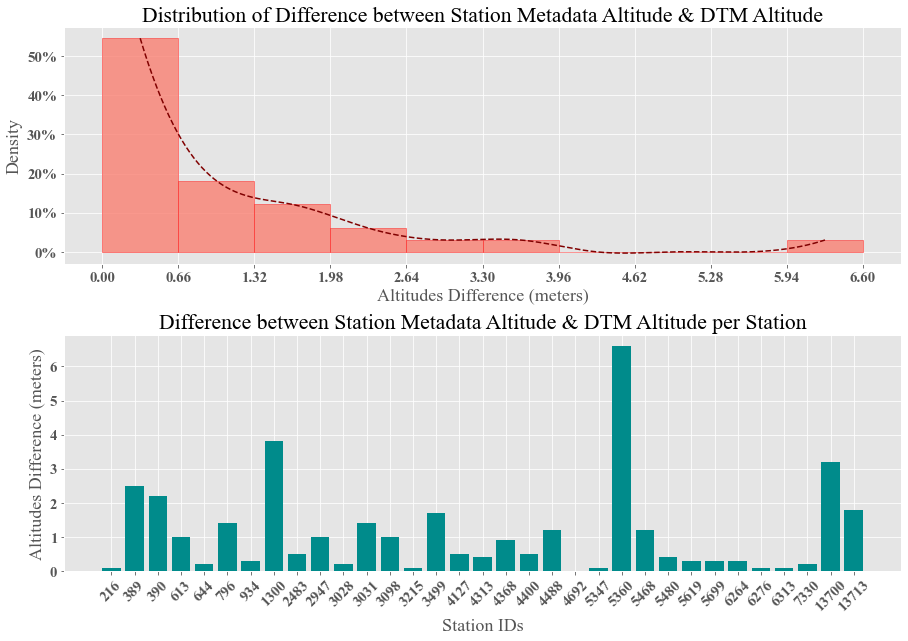

In [63]:
# Plot the difference between Station Metadata Altitude & DTM Altitude per station and create a density plot
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 10))
font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 15}
plt.rc('font', **font)
gs = GridSpec(2, 1)
gs.update(hspace=0.3)

# Density plot
gs00 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0], hspace=0)
ax0 = fig.add_subplot(gs00[0])
n, bins, patches = ax0.hist(df_altitude_difference['difference'],
                            weights=np.ones(len(df_altitude_difference['difference']))
                                    / len(df_altitude_difference['difference']),
                            color='salmon', edgecolor='red', alpha=0.8)
ax0.yaxis.set_major_formatter(PercentFormatter(1))
x = bins[:-1] + (bins[1] - bins[0])/2
# Plot a smooth curve
model = make_interp_spline(x, n)
xs = np.linspace(x.min(), x.max(), 500)
ys = model(xs)
ax0.plot(xs, ys, '--', color='maroon')
ax0.set_xticks(bins)
ax0.set_xlabel('Altitudes Difference (meters)')
ax0.set_ylabel('Density')
ax0.set_title('Distribution of Difference between Station Metadata Altitude & DTM Altitude')

# Difference per station
gs01 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1], hspace=0)
ax1 = fig.add_subplot(gs01[0])
ax1.bar(df_altitude_difference['stations_id'].astype(str),
        df_altitude_difference['difference'], linewidth=3.0, color='darkcyan')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xlabel('Station IDs')
ax1.set_ylabel('Altitudes Difference (meters)')
ax1.set_title('Difference between Station Metadata Altitude & DTM Altitude per Station')

plt.show()

